In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Step 1 - Exploratory Climate Analysis

In [10]:
measurement_row = session.query(Measurement).first()
measurement_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x219500174e0>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [11]:
station_row = session.query(Station).first()
station_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x21950017c18>,
 'id': 1,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [12]:
#find the last date
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(last_date)

2017-08-23


In [13]:
#find the date from 1 year ago
year_ago_last_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(year_ago_last_date)

2016-08-23


### Precipitation Analysis

In [14]:
#Design a query to retrieve the last 12 months of precipitation data
#Only select the data dates great than 2016-08-23
prep_select= session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago_last_date).\
    filter(Measurement.date <=last_date).\
    order_by(Measurement.date).all()
# show the first 10 elements in the list
prep_select[:10]

[('2016-08-23', 0.0),
 ('2016-08-23', 0.15),
 ('2016-08-23', 0.05),
 ('2016-08-23', None),
 ('2016-08-23', 0.02),
 ('2016-08-23', 1.79),
 ('2016-08-23', 0.7),
 ('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28)]

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prep_select_df = pd.DataFrame(prep_select, columns=['date', 'precipitation'])

#sort by date
prep_select_df.sort_values(by=['date'])

#set date as index
prep_select_df=prep_select_df.set_index('date')
prep_select_df.head(10)

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


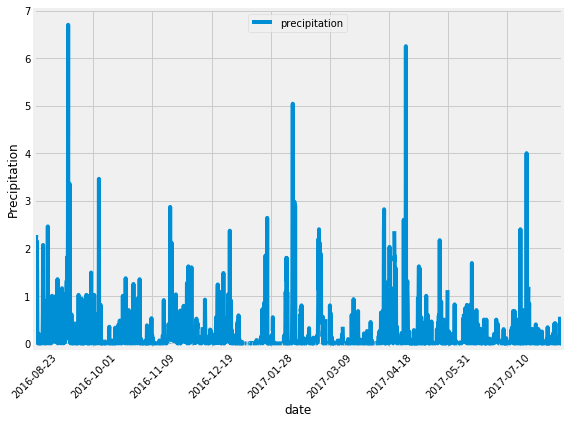

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
prep_select_df.plot(figsize=(8,6),rot=45)
#ax.xaxis.set_major_formatter(plt.NullFormatter())
# set plot 
plt.ylabel("Precipitation")
plt.xlabel("date")
plt.tight_layout()
plt.legend(loc='upper center')
plt.ylim(-0.1)
plt.savefig('output_data/precipitation plot')
plt.show()


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prep_select_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [18]:
# Design a query to show how many stations are available in this dataset?
total_station=session.query(Station.id).count()
print("There are " + str(total_station)+ " stations")

There are 9 stations


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
#station has the hiest number of obervations
most_act_station=session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()
print(f"The most active station is {most_act_station[0]}, total counts are {most_act_station[1]}")

The most active station is USC00519281, total counts are 2772


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_highob=session.query(Measurement.tobs).\
    filter(Measurement.station == most_act_station[0]).\
    filter(Measurement.date >= year_ago_last_date).all()

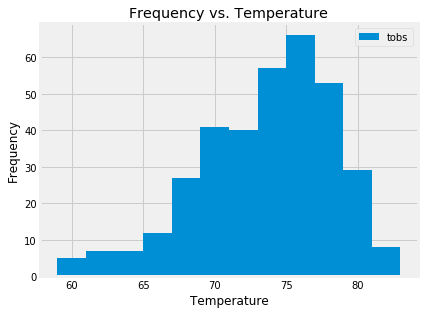

In [23]:
station_highob_df = pd.DataFrame(station_highob, columns=['tobs'])
station_highob_df.plot.hist(bins=12)
plt.tight_layout()
plt.title("Frequency vs. Temperature")
plt.xlabel("Temperature")
plt.savefig('output_data/Highest Observation Station Data plot')
plt.show()

### Optional: Other Recommended Analyses

### Temperature Analysis I

In [24]:
from scipy.stats import sem,ttest_ind

In [25]:
#Query for all month matching the target month
month_str1="06"
temp_jun=session.query(Measurement.tobs).\
    filter(func.strftime("%m",Measurement.date)== month_str1).\
    order_by(Measurement.date).all()
temp_jun_avg = np.mean(temp_jun)
temp_jun_sem = sem(np.ravel(temp_jun))


month_str2="12"
temp_dec=session.query(Measurement.tobs).\
    filter(func.strftime("%m",Measurement.date)== month_str2).\
    order_by(Measurement.date).all()
temp_dec_avg = np.mean(temp_dec)
temp_dec_sem = sem(np.ravel(temp_dec))

means=[temp_jun_avg, temp_dec_avg]
sems =[temp_jun_sem, temp_dec_sem]
labels = ["June Average Temperature","December Average Temperature"]

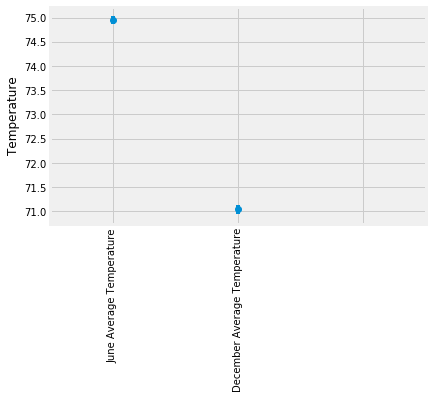

In [26]:
fig, ax = plt.subplots()

ax.errorbar(np.arange(0, len(means)), means, yerr=sems, fmt="o")

ax.set_xlim(-0.5, 2.5)
ax.set_xticklabels(labels, rotation='90')
ax.set_xticks([0, 1, 2])


ax.set_ylabel("Temperature")
plt.savefig ('output_data/Average Temperature Comparision')
plt.show()

In [27]:
# t-test
(t_stat, p) = ttest_ind(temp_jun, temp_dec, equal_var=False)

if p < 0.05:
    print("The temperature differences between the June and December are significant.")
else:
    print("The temperature differences between June and  December are due to chance.")

The temperature differences between the June and December are significant.


### Temperature Analysis II

In [28]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.date(2018, 1, 1)
end_date = dt.date(2018, 1, 7)

# Get dates for previous year
last_start_date = start_date - dt.timedelta(days=365)
last_end_date = end_date - dt.timedelta(days=365)

trip_temps = calc_temps(last_start_date,last_end_date)
trip_temps
#There is no information for these dates

[(62.0, 68.36585365853658, 74.0)]

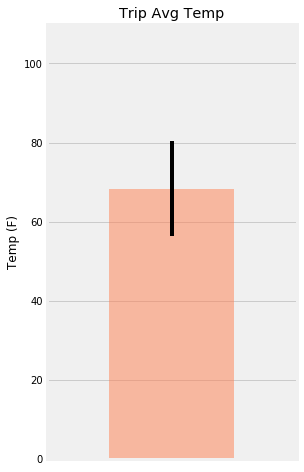

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tripT_df = pd.DataFrame(trip_temps, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = tripT_df['Avg Temp']
delta_temp = tripT_df['Max Temp'] - tripT_df['Min Temp']
avg_temp.plot(kind='bar', yerr=delta_temp, figsize=(4,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])
plt.margins(0.2)
plt.ylim(0,110)
plt.grid
plt.savefig("output_data/TripTempSummary.png")
plt.show()

In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel=[Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
trip_data = session.query(*sel).\
    group_by(Measurement.station).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= last_start_date).\
    filter(Measurement.date <= last_end_date).\
    order_by(func.sum(Measurement.prcp).desc()).all()

for record in trip_data:
    (m_s,s_n,s_lat,s_lon,s_e,m_prcp) = record
    print(
        f"Station:{m_s} Name:{s_n} Latitude:{s_lat} Longitude:{s_lon} Station:{s_e} Total RainFall:{m_prcp}\n ")
        

Station:USC00519523 Name:WAIMANALO EXPERIMENTAL FARM, HI US Latitude:21.33556 Longitude:-157.71139 Station:19.5 Total RainFall:0.61
 
Station:USC00514830 Name:KUALOA RANCH HEADQUARTERS 886.9, HI US Latitude:21.5213 Longitude:-157.8374 Station:7.0 Total RainFall:0.6
 
Station:USC00516128 Name:MANOA LYON ARBO 785.2, HI US Latitude:21.3331 Longitude:-157.8025 Station:152.4 Total RainFall:0.6
 
Station:USC00513117 Name:KANEOHE 838.1, HI US Latitude:21.4234 Longitude:-157.8015 Station:14.6 Total RainFall:0.35
 
Station:USC00519281 Name:WAIHEE 837.5, HI US Latitude:21.45167 Longitude:-157.84888999999998 Station:32.9 Total RainFall:0.2
 
Station:USC00519397 Name:WAIKIKI 717.2, HI US Latitude:21.2716 Longitude:-157.8168 Station:3.0 Total RainFall:0.0
 


### Daily Rainfall Average

In [32]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.date(2018, 1, 1)
end_date = dt.date(2018, 1, 7)

# for your trip using the previous year's data for those same dates.
last_start_date = start_date - dt.timedelta(days=365)
last_end_date = end_date - dt.timedelta(days=365)

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
last_trip_dates = pd.date_range(last_start_date, last_end_date)
trip_day = last_trip_dates.strftime('%m-%d')

# Converting them to a list of strings
trip_day_list=trip_day.tolist()

# Loop through the list of %m-%d strings and calculate the normals for each date
norm_list=[]
for day in trip_day_list:
    norm_list.append(*daily_normals(day))
norm_list

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
norm_df = pd.DataFrame(norm_list, columns = ['Tmin', 'Tavg', 'Tmax'])
# Modifiy index
trip_dates = pd.date_range(start_date, end_date)
trip_dates = trip_dates.strftime('%Y-%m-%d')
norm_df['Date'] = trip_dates
norm_df = norm_df.set_index('Date')
norm_df

,Tmin,Tavg,Tmax
Date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


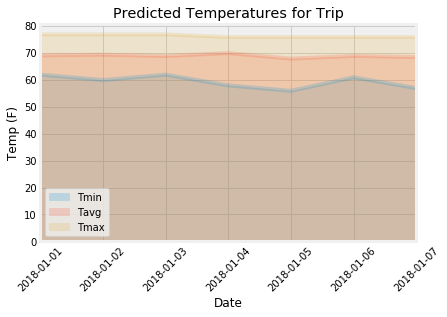

In [35]:
#make an area plot for the predicted temps
norm_df.plot(kind='area', stacked=False,alpha=0.2, rot=45)
plt.title('Predicted Temperatures for Trip')
plt.ylabel('Temp (F)')
plt.savefig("output_data/Predicted Temperatures for Trip.png")
plt.show()